In [1]:
import scanpy as sc
import numpy as np

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
adata=sc.read_h5ad("./data/t1d.h5ad")
print(adata)
print(adata.X[:10,:10])

AnnData object with n_obs × n_vars = 69645 × 26099
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'disease_state', 'cell_label', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'
  (0, 1)	1.076574683189392
  (3, 1)	0.6022599935531616
  (4, 1)	0.32389

In [3]:
import pandas as pd
df = pd.DataFrame(adata.obs[['disease_state','donor_id']].copy())

# Remove duplicated rows
unique_df = df.drop_duplicates()

# Construct a dictionary mapping the first column to the second column
mapping_dict = dict(zip(unique_df['donor_id'], unique_df['disease_state']))

print("Unique DataFrame:")
print(unique_df)
print("\nMapping Dictionary:")
print(mapping_dict)

Unique DataFrame:
                    disease_state donor_id
AAACCTGAGGTGTGGT-1        Control  HPAP022
AAACCTGCACCTTGTC-2        Control  HPAP026
AAACGGGAGTAGCGGT-3        Control  HPAP034
AAACCTGCAGCTGTAT-4        Control  HPAP035
AAACCTGAGACGCAAC-5        Control  HPAP036
AAACCTGCACCAGATT-6        Control  HPAP037
AAACCCAAGGACATCG-7        Control  HPAP039
AAACCCAAGTAGTCAA-8        Control  HPAP040
AAACCCACAACCTAAC-9        Control  HPAP042
AAACGAACAAGCGCTC-10       Control  HPAP044
AAACCCAAGCCTCTGG-11       Control  HPAP047
AAACCTGAGACTGTAA-12           AAB  HPAP019
AAACCTGCAATGGATA-13           AAB  HPAP024
AAACCTGGTTCTGGTA-14           AAB  HPAP029
AAACCCACAGACTCTA-15           AAB  HPAP038
AAACGAAAGAATCGTA-16           AAB  HPAP043
AAACCCAAGACCATAA-17           AAB  HPAP045
AAACCCAAGCGCGTTC-18           AAB  HPAP049
AAACCCACAGTATTCG-19           AAB  HPAP050
AAACCTGAGGCACATG-20           T1D  HPAP020
AAACCTGAGCGTTGCC-21           T1D  HPAP021
AAACCTGCATCCTAGA-22           T1D  H

# Condition label permutation for each donor_id

Permute the condition label for each donor_id

In [4]:
# Extract keys and values
keys = list(mapping_dict.keys())
values = list(mapping_dict.values())
# Shuffle the values
random.shuffle(values)
# Create a new dictionary with permuted values
permuted_dict = dict(zip(keys, values))
print(permuted_dict)

{'HPAP022': 'AAB', 'HPAP026': 'AAB', 'HPAP034': 'Control', 'HPAP035': 'AAB', 'HPAP036': 'Control', 'HPAP037': 'AAB', 'HPAP039': 'Control', 'HPAP040': 'Control', 'HPAP042': 'T1D', 'HPAP044': 'AAB', 'HPAP047': 'AAB', 'HPAP019': 'T1D', 'HPAP024': 'Control', 'HPAP029': 'T1D', 'HPAP038': 'Control', 'HPAP043': 'Control', 'HPAP045': 'AAB', 'HPAP049': 'T1D', 'HPAP050': 'Control', 'HPAP020': 'T1D', 'HPAP021': 'AAB', 'HPAP023': 'Control', 'HPAP028': 'Control', 'HPAP032': 'Control'}


In [5]:
disease_state_fake=[]
for i in range(adata.shape[0]):
    disease_state_fake.append(permuted_dict[adata.obs["donor_id"][i]])
adata.obs['disease_state_fake']=np.array(disease_state_fake)

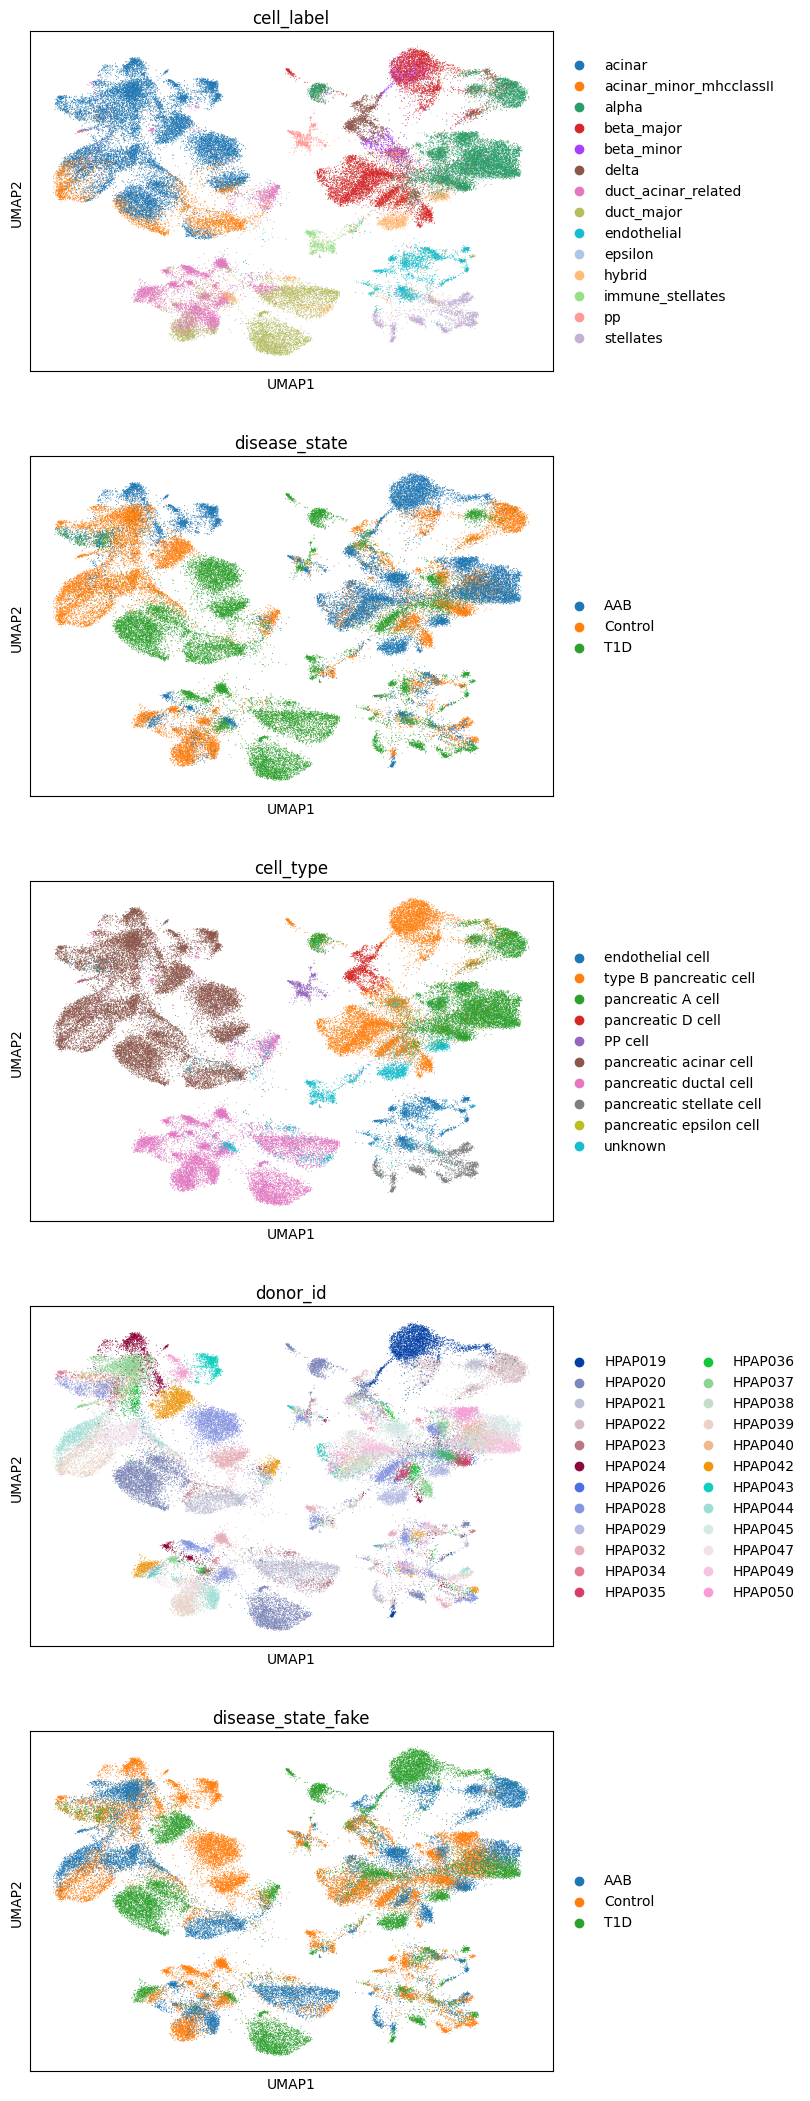

In [6]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["cell_label","disease_state","cell_type","donor_id",'disease_state_fake'],ncols=1)

In [7]:
from ndreamer import NDreamer

model = NDreamer(adata, condition_key="disease_state_fake", contorl_name='Control', num_hvg=2000, require_batch=True,
                            batch_key='donor_id',
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=2048, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./t1d_fake/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./t1d_fake/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: <class 'torch.cuda.device'>
1
Start data preprocessing
Original adata.obs[donor_id] back up to adata.obs['batch_backup']
Original adata.obs[disease_state_fake] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'Control': 0, 'AAB': 1, 'T1D': 2}
Condition mapping to adata.obs['batch']: {'donor_id': {'HPAP022': 0, 'HPAP026': 1, 'HPAP034': 2, 'HPAP035': 3, 'HPAP036': 4, 'HPAP037': 5, 'HPAP039': 6, 'HPAP040': 7, 'HPAP042': 8, 'HPAP044': 9, 'HPAP047': 10, 'HPAP019': 11, 'HPAP024': 12, 'HPAP029': 13, 'HPAP038': 14, 'HPAP043': 15, 'HPAP045': 16, 'HPAP049': 17, 'HPAP050': 18, 'HPAP020': 19, 'HPAP021': 20, 'HPAP023': 21, 'HPAP028': 22, 'HPAP032': 23}}
Unique batch mapping: {'HPAP022': 0, 'HPAP026': 1, 'HPAP034': 2, 'HPAP035': 3, 'HPAP036': 4, 'HPAP037': 5, 'HPAP039': 6, 'HPAP040': 7, 'HPAP042': 8, 'HPAP044': 9, 'HPAP047': 10, 'HPAP019': 11, 'HPAP024': 12, 'HPAP029': 13, 'HPAP038': 14, 'HPAP043': 15, 'HPAP045': 16, 'HPAP049': 17, 'HPAP050': 18, '

Calculating the clusters
Unique groups: ['0_AAB' '10_AAB' '11_T1D' '12_Control' '13_T1D' '14_Control' '15_Control'
 '16_AAB' '17_T1D' '18_Control' '19_T1D' '1_AAB' '20_AAB' '21_Control'
 '22_Control' '23_Control' '2_Control' '3_AAB' '4_Control' '5_AAB'
 '6_Control' '7_Control' '8_T1D' '9_AAB']


Finished clustering
Data preprocessing done


Remaining number of cells: 69645
Too few epoches (steps, if rigorously speaking). Changing epoch to 22 to adjust for number of cells
Require batch: True
Batch name to number mapping (may be used for search for saved adata):
 {'donor_id': {'HPAP022': 0, 'HPAP026': 1, 'HPAP034': 2, 'HPAP035': 3, 'HPAP036': 4, 'HPAP037': 5, 'HPAP039': 6, 'HPAP040': 7, 'HPAP042': 8, 'HPAP044': 9, 'HPAP047': 10, 'HPAP019': 11, 'HPAP024': 12, 'HPAP029': 13, 'HPAP038': 14, 'HPAP043': 15, 'HPAP045': 16, 'HPAP049': 17, 'HPAP050': 18, 'HPAP020': 19, 'HPAP021': 20, 'HPAP023': 21, 'HPAP028': 22, 'HPAP032': 23}}
Condition name to number mapping (may be used for search for saved adata):
 {'Control': 0, 'AAB': 1, 'T1D': 2}
Preprocessing time: 67.47638 seconds


Overall Progress:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 1/22 | All Loss: 144.0937 | Neighborhood Loss: 38.8366 | Triplet Loss: 9.3500 | Reconstruction Loss: 8.5537 | Independent Loss: 94.4624 | KL Loss: 0.3346 | Commitment Loss: 0.5612 | Dependent Loss: -8.0049


Resetting 786 unused embeddings.
Resetting 778 unused embeddings.


Resetting 772 unused embeddings.
Resetting 751 unused embeddings.


Resetting 784 unused embeddings.
Resetting 771 unused embeddings.


Resetting 765 unused embeddings.
Resetting 795 unused embeddings.


Resetting 747 unused embeddings.
Resetting 764 unused embeddings.


Resetting 767 unused embeddings.
Resetting 770 unused embeddings.


Resetting 773 unused embeddings.
Resetting 752 unused embeddings.


Resetting 752 unused embeddings.
Resetting 769 unused embeddings.


Resetting 769 unused embeddings.
Resetting 767 unused embeddings.


Resetting 779 unused embeddings.
Resetting 770 unused embeddings.


Resetting 769 unused embeddings.
Resetting 783 unused embeddings.


Resetting 775 unused embeddings.
Resetting 760 unused embeddings.


Resetting 746 unused embeddings.
Resetting 788 unused embeddings.


Resetting 776 unused embeddings.
Resetting 809 unused embeddings.


Resetting 748 unused embeddings.
Resetting 762 unused embeddings.


Resetting 746 unused embeddings.
Resetting 776 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 1


Epoch: 2/22 | All Loss: 80.1665 | Neighborhood Loss: 36.3945 | Triplet Loss: 5.5657 | Reconstruction Loss: 5.5064 | Independent Loss: 36.9355 | KL Loss: 0.1442 | Commitment Loss: 0.2393 | Dependent Loss: -4.6191


Resetting 671 unused embeddings.
Resetting 713 unused embeddings.


Resetting 684 unused embeddings.
Resetting 636 unused embeddings.


Resetting 643 unused embeddings.
Resetting 757 unused embeddings.


Resetting 699 unused embeddings.
Resetting 736 unused embeddings.


Resetting 685 unused embeddings.
Resetting 698 unused embeddings.


Resetting 648 unused embeddings.
Resetting 743 unused embeddings.


Resetting 710 unused embeddings.
Resetting 683 unused embeddings.


Resetting 689 unused embeddings.
Resetting 668 unused embeddings.


Resetting 669 unused embeddings.
Resetting 648 unused embeddings.


Resetting 739 unused embeddings.
Resetting 692 unused embeddings.


Resetting 673 unused embeddings.
Resetting 702 unused embeddings.


Resetting 670 unused embeddings.
Resetting 635 unused embeddings.


Resetting 775 unused embeddings.
Resetting 665 unused embeddings.


Resetting 754 unused embeddings.
Resetting 751 unused embeddings.


Resetting 704 unused embeddings.
Resetting 658 unused embeddings.


Resetting 748 unused embeddings.
Resetting 620 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 2


Epoch: 3/22 | All Loss: 64.2878 | Neighborhood Loss: 35.5096 | Triplet Loss: 4.8779 | Reconstruction Loss: 5.2850 | Independent Loss: 21.5079 | KL Loss: 0.1020 | Commitment Loss: 0.1529 | Dependent Loss: -3.1474


Resetting 674 unused embeddings.
Resetting 660 unused embeddings.


Resetting 693 unused embeddings.
Resetting 641 unused embeddings.


Resetting 655 unused embeddings.
Resetting 712 unused embeddings.


Resetting 696 unused embeddings.
Resetting 748 unused embeddings.


Resetting 699 unused embeddings.
Resetting 660 unused embeddings.


Resetting 660 unused embeddings.
Resetting 719 unused embeddings.


Resetting 698 unused embeddings.
Resetting 662 unused embeddings.


Resetting 607 unused embeddings.
Resetting 652 unused embeddings.


Resetting 656 unused embeddings.
Resetting 642 unused embeddings.


Resetting 746 unused embeddings.


Resetting 690 unused embeddings.
Resetting 633 unused embeddings.


Resetting 689 unused embeddings.
Resetting 655 unused embeddings.


Resetting 653 unused embeddings.
Resetting 714 unused embeddings.


Resetting 670 unused embeddings.
Resetting 747 unused embeddings.


Resetting 716 unused embeddings.
Resetting 700 unused embeddings.


Resetting 662 unused embeddings.
Resetting 739 unused embeddings.


Resetting 638 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 3


Epoch: 4/22 | All Loss: 60.3327 | Neighborhood Loss: 34.5942 | Triplet Loss: 4.3723 | Reconstruction Loss: 5.0423 | Independent Loss: 19.0898 | KL Loss: 0.0952 | Commitment Loss: 0.1309 | Dependent Loss: -2.9920


Resetting 689 unused embeddings.
Resetting 671 unused embeddings.


Resetting 701 unused embeddings.
Resetting 662 unused embeddings.


Resetting 663 unused embeddings.
Resetting 721 unused embeddings.


Resetting 691 unused embeddings.
Resetting 753 unused embeddings.


Resetting 705 unused embeddings.
Resetting 677 unused embeddings.


Resetting 671 unused embeddings.
Resetting 724 unused embeddings.


Resetting 693 unused embeddings.
Resetting 679 unused embeddings.


Resetting 624 unused embeddings.
Resetting 660 unused embeddings.


Resetting 654 unused embeddings.
Resetting 646 unused embeddings.


Resetting 752 unused embeddings.
Resetting 701 unused embeddings.


Resetting 649 unused embeddings.
Resetting 680 unused embeddings.


Resetting 677 unused embeddings.
Resetting 671 unused embeddings.


Resetting 704 unused embeddings.
Resetting 678 unused embeddings.


Resetting 750 unused embeddings.


Resetting 705 unused embeddings.


Resetting 714 unused embeddings.
Resetting 665 unused embeddings.


Resetting 730 unused embeddings.
Resetting 654 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 4
Epoch: 5/22 | All Loss: 57.5062 | Neighborhood Loss: 33.3268 | Triplet Loss: 4.0676 | Reconstruction Loss: 4.8431 | Independent Loss: 18.1319 | KL Loss: 0.0947 | Commitment Loss: 0.1264 | Dependent Loss: -3.0842


Epoch: 6/22 | All Loss: 58.3789 | Neighborhood Loss: 34.9194 | Triplet Loss: 3.9374 | Reconstruction Loss: 4.9897 | Independent Loss: 17.3857 | KL Loss: 0.1008 | Commitment Loss: 0.1312 | Dependent Loss: -3.0854


Resetting 691 unused embeddings.
Resetting 681 unused embeddings.


Resetting 695 unused embeddings.
Resetting 677 unused embeddings.


Resetting 674 unused embeddings.
Resetting 720 unused embeddings.


Resetting 694 unused embeddings.
Resetting 757 unused embeddings.


Resetting 708 unused embeddings.
Resetting 681 unused embeddings.


Resetting 685 unused embeddings.
Resetting 723 unused embeddings.


Resetting 694 unused embeddings.


Resetting 686 unused embeddings.


Resetting 640 unused embeddings.
Resetting 675 unused embeddings.


Resetting 665 unused embeddings.
Resetting 658 unused embeddings.


Resetting 752 unused embeddings.
Resetting 709 unused embeddings.


Resetting 653 unused embeddings.
Resetting 680 unused embeddings.


Resetting 689 unused embeddings.
Resetting 681 unused embeddings.


Resetting 707 unused embeddings.
Resetting 680 unused embeddings.


Resetting 748 unused embeddings.


Resetting 701 unused embeddings.
Resetting 712 unused embeddings.


Resetting 670 unused embeddings.


Resetting 733 unused embeddings.


Resetting 658 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 6


Epoch: 7/22 | All Loss: 55.0418 | Neighborhood Loss: 33.2361 | Triplet Loss: 3.8707 | Reconstruction Loss: 4.7382 | Independent Loss: 15.9159 | KL Loss: 0.0958 | Commitment Loss: 0.1285 | Dependent Loss: -2.9434


Resetting 694 unused embeddings.
Resetting 694 unused embeddings.


Resetting 696 unused embeddings.
Resetting 683 unused embeddings.


Resetting 684 unused embeddings.
Resetting 722 unused embeddings.


Resetting 698 unused embeddings.
Resetting 758 unused embeddings.


Resetting 709 unused embeddings.
Resetting 688 unused embeddings.


Resetting 689 unused embeddings.
Resetting 723 unused embeddings.


Resetting 696 unused embeddings.


Resetting 696 unused embeddings.


Resetting 655 unused embeddings.
Resetting 680 unused embeddings.


Resetting 677 unused embeddings.
Resetting 667 unused embeddings.


Resetting 753 unused embeddings.
Resetting 718 unused embeddings.


Resetting 662 unused embeddings.


Resetting 688 unused embeddings.


Resetting 696 unused embeddings.
Resetting 685 unused embeddings.


Resetting 714 unused embeddings.
Resetting 683 unused embeddings.


Resetting 743 unused embeddings.
Resetting 706 unused embeddings.


Resetting 724 unused embeddings.
Resetting 674 unused embeddings.


Resetting 732 unused embeddings.
Resetting 662 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 7


Epoch: 8/22 | All Loss: 54.3183 | Neighborhood Loss: 32.7353 | Triplet Loss: 3.6077 | Reconstruction Loss: 4.6722 | Independent Loss: 16.2860 | KL Loss: 0.0995 | Commitment Loss: 0.1343 | Dependent Loss: -3.2168


Resetting 701 unused embeddings.
Resetting 699 unused embeddings.


Resetting 709 unused embeddings.
Resetting 689 unused embeddings.


Resetting 686 unused embeddings.
Resetting 722 unused embeddings.


Resetting 694 unused embeddings.
Resetting 759 unused embeddings.


Resetting 718 unused embeddings.


Resetting 698 unused embeddings.
Resetting 696 unused embeddings.


Resetting 729 unused embeddings.
Resetting 702 unused embeddings.


Resetting 706 unused embeddings.
Resetting 664 unused embeddings.


Resetting 689 unused embeddings.
Resetting 684 unused embeddings.


Resetting 672 unused embeddings.
Resetting 727 unused embeddings.


Resetting 733 unused embeddings.
Resetting 670 unused embeddings.


Resetting 690 unused embeddings.
Resetting 704 unused embeddings.


Resetting 690 unused embeddings.
Resetting 719 unused embeddings.


Resetting 692 unused embeddings.
Resetting 727 unused embeddings.


Resetting 711 unused embeddings.
Resetting 736 unused embeddings.


Resetting 673 unused embeddings.
Resetting 742 unused embeddings.


Resetting 665 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 8


Epoch: 9/22 | All Loss: 53.3007 | Neighborhood Loss: 32.0078 | Triplet Loss: 3.5660 | Reconstruction Loss: 4.6155 | Independent Loss: 16.2032 | KL Loss: 0.1017 | Commitment Loss: 0.1377 | Dependent Loss: -3.3311


Resetting 708 unused embeddings.
Resetting 710 unused embeddings.


Resetting 712 unused embeddings.
Resetting 697 unused embeddings.


Resetting 688 unused embeddings.
Resetting 729 unused embeddings.


Resetting 692 unused embeddings.
Resetting 760 unused embeddings.


Resetting 727 unused embeddings.
Resetting 706 unused embeddings.


Resetting 698 unused embeddings.
Resetting 730 unused embeddings.


Resetting 705 unused embeddings.
Resetting 714 unused embeddings.


Resetting 672 unused embeddings.
Resetting 695 unused embeddings.


Resetting 691 unused embeddings.
Resetting 677 unused embeddings.


Resetting 731 unused embeddings.
Resetting 740 unused embeddings.


Resetting 672 unused embeddings.
Resetting 694 unused embeddings.


Resetting 711 unused embeddings.
Resetting 699 unused embeddings.


Resetting 728 unused embeddings.
Resetting 702 unused embeddings.


Resetting 729 unused embeddings.
Resetting 716 unused embeddings.


Resetting 738 unused embeddings.
Resetting 680 unused embeddings.


Resetting 745 unused embeddings.
Resetting 668 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 9
Epoch: 10/22 | All Loss: 52.1397 | Neighborhood Loss: 31.7157 | Triplet Loss: 3.4262 | Reconstruction Loss: 4.5584 | Independent Loss: 15.5146 | KL Loss: 0.0997 | Commitment Loss: 0.1388 | Dependent Loss: -3.3136


Epoch: 11/22 | All Loss: 53.7021 | Neighborhood Loss: 33.2776 | Triplet Loss: 3.4339 | Reconstruction Loss: 4.7413 | Independent Loss: 15.1649 | KL Loss: 0.1110 | Commitment Loss: 0.1469 | Dependent Loss: -3.1734


Resetting 713 unused embeddings.
Resetting 713 unused embeddings.


Resetting 711 unused embeddings.
Resetting 707 unused embeddings.


Resetting 692 unused embeddings.
Resetting 736 unused embeddings.


Resetting 697 unused embeddings.
Resetting 755 unused embeddings.


Resetting 734 unused embeddings.
Resetting 712 unused embeddings.


Resetting 705 unused embeddings.
Resetting 733 unused embeddings.


Resetting 710 unused embeddings.
Resetting 717 unused embeddings.


Resetting 682 unused embeddings.
Resetting 698 unused embeddings.


Resetting 696 unused embeddings.
Resetting 682 unused embeddings.


Resetting 738 unused embeddings.
Resetting 744 unused embeddings.


Resetting 681 unused embeddings.
Resetting 696 unused embeddings.


Resetting 716 unused embeddings.
Resetting 703 unused embeddings.


Resetting 732 unused embeddings.
Resetting 706 unused embeddings.


Resetting 733 unused embeddings.
Resetting 719 unused embeddings.


Resetting 741 unused embeddings.
Resetting 685 unused embeddings.


Resetting 747 unused embeddings.
Resetting 672 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 11


Epoch: 12/22 | All Loss: 51.3207 | Neighborhood Loss: 31.8787 | Triplet Loss: 3.3571 | Reconstruction Loss: 4.4982 | Independent Loss: 14.3968 | KL Loss: 0.1023 | Commitment Loss: 0.1414 | Dependent Loss: -3.0538


Resetting 721 unused embeddings.
Resetting 715 unused embeddings.


Resetting 717 unused embeddings.
Resetting 715 unused embeddings.


Resetting 696 unused embeddings.
Resetting 741 unused embeddings.


Resetting 703 unused embeddings.
Resetting 756 unused embeddings.


Resetting 742 unused embeddings.
Resetting 723 unused embeddings.


Resetting 709 unused embeddings.
Resetting 751 unused embeddings.


Resetting 721 unused embeddings.
Resetting 718 unused embeddings.


Resetting 686 unused embeddings.
Resetting 702 unused embeddings.


Resetting 704 unused embeddings.
Resetting 688 unused embeddings.


Resetting 728 unused embeddings.
Resetting 752 unused embeddings.


Resetting 683 unused embeddings.
Resetting 700 unused embeddings.


Resetting 720 unused embeddings.
Resetting 704 unused embeddings.


Resetting 738 unused embeddings.
Resetting 710 unused embeddings.


Resetting 738 unused embeddings.
Resetting 724 unused embeddings.


Resetting 738 unused embeddings.
Resetting 687 unused embeddings.


Resetting 748 unused embeddings.
Resetting 680 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 12


Epoch: 13/22 | All Loss: 50.1098 | Neighborhood Loss: 31.2525 | Triplet Loss: 3.0849 | Reconstruction Loss: 4.4807 | Independent Loss: 14.0737 | KL Loss: 0.1063 | Commitment Loss: 0.1424 | Dependent Loss: -3.0307


Resetting 726 unused embeddings.
Resetting 720 unused embeddings.


Resetting 718 unused embeddings.
Resetting 717 unused embeddings.


Resetting 695 unused embeddings.
Resetting 748 unused embeddings.


Resetting 709 unused embeddings.
Resetting 758 unused embeddings.


Resetting 744 unused embeddings.
Resetting 731 unused embeddings.


Resetting 712 unused embeddings.
Resetting 755 unused embeddings.


Resetting 728 unused embeddings.


Resetting 718 unused embeddings.
Resetting 690 unused embeddings.


Resetting 707 unused embeddings.
Resetting 710 unused embeddings.


Resetting 695 unused embeddings.
Resetting 724 unused embeddings.


Resetting 761 unused embeddings.
Resetting 686 unused embeddings.


Resetting 704 unused embeddings.
Resetting 725 unused embeddings.


Resetting 711 unused embeddings.
Resetting 738 unused embeddings.


Resetting 719 unused embeddings.
Resetting 744 unused embeddings.


Resetting 722 unused embeddings.
Resetting 743 unused embeddings.


Resetting 693 unused embeddings.
Resetting 746 unused embeddings.


Resetting 681 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 13


Epoch: 14/22 | All Loss: 50.6009 | Neighborhood Loss: 31.3643 | Triplet Loss: 3.2914 | Reconstruction Loss: 4.3962 | Independent Loss: 14.4371 | KL Loss: 0.1034 | Commitment Loss: 0.1469 | Dependent Loss: -3.1385


Resetting 726 unused embeddings.
Resetting 724 unused embeddings.


Resetting 719 unused embeddings.
Resetting 721 unused embeddings.


Resetting 697 unused embeddings.
Resetting 754 unused embeddings.


Resetting 706 unused embeddings.
Resetting 762 unused embeddings.


Resetting 749 unused embeddings.
Resetting 738 unused embeddings.


Resetting 715 unused embeddings.
Resetting 761 unused embeddings.


Resetting 733 unused embeddings.
Resetting 720 unused embeddings.


Resetting 696 unused embeddings.
Resetting 712 unused embeddings.


Resetting 712 unused embeddings.
Resetting 701 unused embeddings.


Resetting 712 unused embeddings.
Resetting 766 unused embeddings.


Resetting 690 unused embeddings.
Resetting 709 unused embeddings.


Resetting 730 unused embeddings.
Resetting 713 unused embeddings.


Resetting 741 unused embeddings.
Resetting 723 unused embeddings.


Resetting 741 unused embeddings.
Resetting 725 unused embeddings.


Resetting 744 unused embeddings.
Resetting 694 unused embeddings.


Resetting 746 unused embeddings.
Resetting 684 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 14
Epoch: 15/22 | All Loss: 50.8651 | Neighborhood Loss: 31.6928 | Triplet Loss: 3.2464 | Reconstruction Loss: 4.4017 | Independent Loss: 14.1318 | KL Loss: 0.1028 | Commitment Loss: 0.1534 | Dependent Loss: -2.8638


Epoch: 16/22 | All Loss: 51.4642 | Neighborhood Loss: 32.1073 | Triplet Loss: 3.2413 | Reconstruction Loss: 4.5643 | Independent Loss: 14.2296 | KL Loss: 0.1059 | Commitment Loss: 0.1548 | Dependent Loss: -2.9391


Resetting 729 unused embeddings.
Resetting 726 unused embeddings.


Resetting 726 unused embeddings.
Resetting 725 unused embeddings.


Resetting 699 unused embeddings.
Resetting 757 unused embeddings.


Resetting 711 unused embeddings.
Resetting 764 unused embeddings.


Resetting 756 unused embeddings.
Resetting 741 unused embeddings.


Resetting 719 unused embeddings.
Resetting 763 unused embeddings.


Resetting 731 unused embeddings.
Resetting 724 unused embeddings.


Resetting 703 unused embeddings.
Resetting 716 unused embeddings.


Resetting 714 unused embeddings.
Resetting 705 unused embeddings.


Resetting 717 unused embeddings.
Resetting 770 unused embeddings.


Resetting 693 unused embeddings.
Resetting 713 unused embeddings.


Resetting 733 unused embeddings.
Resetting 720 unused embeddings.


Resetting 746 unused embeddings.
Resetting 726 unused embeddings.


Resetting 746 unused embeddings.
Resetting 725 unused embeddings.


Resetting 747 unused embeddings.
Resetting 694 unused embeddings.


Resetting 749 unused embeddings.
Resetting 686 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 16


Epoch: 17/22 | All Loss: 48.5417 | Neighborhood Loss: 30.1264 | Triplet Loss: 3.1070 | Reconstruction Loss: 4.3325 | Independent Loss: 13.7606 | KL Loss: 0.1023 | Commitment Loss: 0.1525 | Dependent Loss: -3.0395


Resetting 730 unused embeddings.
Resetting 727 unused embeddings.


Resetting 733 unused embeddings.
Resetting 731 unused embeddings.


Resetting 700 unused embeddings.
Resetting 758 unused embeddings.


Resetting 714 unused embeddings.


Resetting 769 unused embeddings.
Resetting 759 unused embeddings.


Resetting 749 unused embeddings.
Resetting 725 unused embeddings.


Resetting 768 unused embeddings.
Resetting 734 unused embeddings.


Resetting 727 unused embeddings.
Resetting 706 unused embeddings.


Resetting 718 unused embeddings.
Resetting 720 unused embeddings.


Resetting 708 unused embeddings.
Resetting 713 unused embeddings.


Resetting 773 unused embeddings.
Resetting 703 unused embeddings.


Resetting 715 unused embeddings.
Resetting 735 unused embeddings.


Resetting 724 unused embeddings.
Resetting 752 unused embeddings.


Resetting 730 unused embeddings.
Resetting 748 unused embeddings.


Resetting 733 unused embeddings.
Resetting 748 unused embeddings.


Resetting 696 unused embeddings.
Resetting 751 unused embeddings.


Resetting 692 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 17


Epoch: 18/22 | All Loss: 48.1185 | Neighborhood Loss: 29.9001 | Triplet Loss: 2.8304 | Reconstruction Loss: 4.3277 | Independent Loss: 14.0744 | KL Loss: 0.1024 | Commitment Loss: 0.1555 | Dependent Loss: -3.2719


Resetting 734 unused embeddings.
Resetting 729 unused embeddings.


Resetting 735 unused embeddings.
Resetting 732 unused embeddings.


Resetting 703 unused embeddings.
Resetting 760 unused embeddings.


Resetting 718 unused embeddings.
Resetting 772 unused embeddings.


Resetting 764 unused embeddings.
Resetting 753 unused embeddings.


Resetting 725 unused embeddings.
Resetting 774 unused embeddings.


Resetting 739 unused embeddings.
Resetting 730 unused embeddings.


Resetting 710 unused embeddings.
Resetting 720 unused embeddings.


Resetting 719 unused embeddings.
Resetting 708 unused embeddings.


Resetting 716 unused embeddings.
Resetting 776 unused embeddings.


Resetting 710 unused embeddings.
Resetting 716 unused embeddings.


Resetting 735 unused embeddings.


Resetting 725 unused embeddings.
Resetting 761 unused embeddings.


Resetting 732 unused embeddings.
Resetting 756 unused embeddings.


Resetting 733 unused embeddings.
Resetting 748 unused embeddings.


Resetting 699 unused embeddings.
Resetting 748 unused embeddings.


Resetting 694 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 18


Epoch: 19/22 | All Loss: 48.2192 | Neighborhood Loss: 30.0068 | Triplet Loss: 2.6758 | Reconstruction Loss: 4.3168 | Independent Loss: 14.2183 | KL Loss: 0.1048 | Commitment Loss: 0.1538 | Dependent Loss: -3.2570


Resetting 737 unused embeddings.
Resetting 732 unused embeddings.


Resetting 737 unused embeddings.
Resetting 731 unused embeddings.


Resetting 705 unused embeddings.
Resetting 759 unused embeddings.


Resetting 728 unused embeddings.
Resetting 772 unused embeddings.


Resetting 766 unused embeddings.
Resetting 759 unused embeddings.


Resetting 727 unused embeddings.
Resetting 779 unused embeddings.


Resetting 742 unused embeddings.
Resetting 731 unused embeddings.


Resetting 708 unused embeddings.
Resetting 724 unused embeddings.


Resetting 723 unused embeddings.
Resetting 712 unused embeddings.


Resetting 719 unused embeddings.
Resetting 780 unused embeddings.


Resetting 713 unused embeddings.
Resetting 720 unused embeddings.


Resetting 738 unused embeddings.
Resetting 729 unused embeddings.


Resetting 768 unused embeddings.
Resetting 732 unused embeddings.


Resetting 757 unused embeddings.
Resetting 736 unused embeddings.


Resetting 753 unused embeddings.
Resetting 703 unused embeddings.


Resetting 756 unused embeddings.
Resetting 696 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 19
Epoch: 20/22 | All Loss: 47.5245 | Neighborhood Loss: 30.0630 | Triplet Loss: 2.9280 | Reconstruction Loss: 4.3135 | Independent Loss: 12.9809 | KL Loss: 0.0997 | Commitment Loss: 0.1490 | Dependent Loss: -3.0096


Epoch: 21/22 | All Loss: 50.7498 | Neighborhood Loss: 31.7732 | Triplet Loss: 3.1435 | Reconstruction Loss: 4.4891 | Independent Loss: 14.1322 | KL Loss: 0.1091 | Commitment Loss: 0.1623 | Dependent Loss: -3.0596


Resetting 739 unused embeddings.
Resetting 733 unused embeddings.


Resetting 737 unused embeddings.


Resetting 731 unused embeddings.


Resetting 707 unused embeddings.
Resetting 758 unused embeddings.


Resetting 734 unused embeddings.
Resetting 772 unused embeddings.


Resetting 767 unused embeddings.
Resetting 759 unused embeddings.


Resetting 731 unused embeddings.
Resetting 781 unused embeddings.


Resetting 745 unused embeddings.
Resetting 734 unused embeddings.


Resetting 710 unused embeddings.
Resetting 729 unused embeddings.


Resetting 724 unused embeddings.
Resetting 717 unused embeddings.


Resetting 721 unused embeddings.
Resetting 784 unused embeddings.


Resetting 717 unused embeddings.
Resetting 725 unused embeddings.


Resetting 738 unused embeddings.
Resetting 732 unused embeddings.


Resetting 773 unused embeddings.
Resetting 732 unused embeddings.


Resetting 761 unused embeddings.
Resetting 736 unused embeddings.


Resetting 757 unused embeddings.
Resetting 706 unused embeddings.


Resetting 758 unused embeddings.
Resetting 701 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 21


Epoch: 22/22 | All Loss: 48.4996 | Neighborhood Loss: 30.8478 | Triplet Loss: 2.9971 | Reconstruction Loss: 4.4016 | Independent Loss: 12.9965 | KL Loss: 0.1068 | Commitment Loss: 0.1531 | Dependent Loss: -3.0033
Model training time: 10755.73273 seconds


Effect modifier space saved.
Model evaluating time: 202.62277 seconds


ITE evaluating: 12.32822 seconds


ITE evaluating: 9.06561 seconds


ITE evaluating: 14.26951 seconds


ITE evaluating: 7.35116 seconds


ITE evaluating: 9.44175 seconds


ITE evaluating: 7.97507 seconds


ITE evaluating: 6.26038 seconds


ITE evaluating: 11.50398 seconds


ITE evaluating: 10.47817 seconds


ITE evaluating: 8.53057 seconds


ITE evaluating: 27.68917 seconds


ITE evaluating: 2.24496 seconds


ITE evaluating: 16.20859 seconds


ITE evaluating: 3.27548 seconds


ITE evaluating: 24.74216 seconds


ITE evaluating: 8.55895 seconds


ITE evaluating: 1.52093 seconds


ITE evaluating: 7.45926 seconds


ITE evaluating: 7.20979 seconds


ITE evaluating: 14.36863 seconds


ITE evaluating: 14.39134 seconds


ITE evaluating: 7.63946 seconds


ITE evaluating: 10.75302 seconds


ITE evaluating: 9.72753 seconds


# Now we evaluate this fake dataset

In [8]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os

from metrics import calculate_metrics

def calculate_mean_proportion_matrix(df):
    """
    Calculates the mean proportion for each combination of condition and neighbor
    and summarizes the result in a square matrix dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe with columns ['condition', 'neighbor', 'proportion'].

    Returns:
    pd.DataFrame: A square matrix dataframe where rows represent 'condition' and columns represent 'neighbor'.
    """
    # Use a pivot table to calculate the mean proportions
    mean_matrix = df.pivot_table(
        index='condition',
        columns='neighbor',
        values='proportion',
        aggfunc='mean',
        fill_value=0  # Replace NaN with 0 if there are missing combinations
    )

    return mean_matrix

def calculate_rowwise_correlation(adata1, adata2, batch_key="batch_all_with_condition"):
    # Ensure the obs index and batch_key match
    #assert np.sum(adata1.obs["batch_all_with_condition"]!=adata2.obs["batch_all_with_condition"])==0, "obs indices do not match between the two AnnData objects"
    assert batch_key in adata1.obs.columns, f"{batch_key} not found in adata1.obs"
    assert batch_key in adata2.obs.columns, f"{batch_key} not found in adata2.obs"

    results = []

    # Iterate through unique batches
    unique_batches = adata1.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the data for the current batch
        batch_mask = adata1.obs[batch_key] == batch
        data1 = adata1[batch_mask].X
        data2 = adata2[batch_mask].X
        
        barcodes=adata1[batch_mask].obs_names.tolist()

        # Ensure the data is in dense format if sparse
        if not isinstance(data1, np.ndarray):
            data1 = data1.toarray()
        if not isinstance(data2, np.ndarray):
            data2 = data2.toarray()

        # Compute correlation for each row
        for i in range(data1.shape[0]):
            row_corr = np.corrcoef(data1[i, :], data2[i, :])[0, 1]
            mse=np.mean(np.square(data1[i, :]-data2[i, :]))
            results.append({"correlation": row_corr, batch_key: batch, "barcode":barcodes[i], "mse":mse})

    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    return result_df


def extract_de_results(adata, batch_key, cell_type_key, key_added="DE_wilcoxon", min_cells=30):
    results = []

    # Iterate through unique batches
    unique_batches = adata.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the AnnData for the current batch
        adata_batch = adata[adata.obs[batch_key] == batch]

        # Filter out cell types with fewer than `min_cells` cells
        cell_counts = adata_batch.obs[cell_type_key].value_counts()
        valid_cell_types = cell_counts[cell_counts >= min_cells].index

        # Subset the AnnData object to only include valid cell types
        adata_batch = adata_batch[adata_batch.obs[cell_type_key].isin(valid_cell_types)]

        # Skip the batch if there are no valid cell types
        if adata_batch.shape[0] == 0 or len(valid_cell_types) == 0:
            continue

        # Perform DE analysis
        sc.tl.rank_genes_groups(adata_batch, groupby=cell_type_key, method='wilcoxon', key_added=key_added, use_raw=False)

        # Extract DE results for each valid cell type
        for cell_type in valid_cell_types:
            # Extract adjusted p-values and gene names
            gene_names = adata_batch.uns[key_added]['names'][cell_type]
            pvals_adj = adata_batch.uns[key_added]['pvals_adj'][cell_type]

            # Create a dictionary for the current cell type and batch
            row_data = {
                "cell_type_key": cell_type,
                "batch_all_with_condition": batch,
            }
            # Add adjusted p-values for each gene as separate columns
            row_data.update({gene: pval for gene, pval in zip(gene_names, pvals_adj)})
            results.append(row_data)

    # Convert results to a DataFrame
    result_df = pd.DataFrame(results)
    return result_df

R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [9]:
def evaluate_ndreamer_batch(dataset_name, cell_type_key, batch_key, condition_key):
    print("adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    adata = sc.read_h5ad("./" + dataset_name + "/adata.h5ad")
    adata.raw = None

    if isinstance(batch_key, str):
        batch_key = [batch_key]

    batch_all = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all.append(tmp)
    batch_all = np.array(batch_all)
    adata.obs["batch_all"] = batch_all
    adata.obs["batch_all"] = adata.obs["batch_all"].astype("category")
    print("batch_all", np.unique(batch_all))

    batch_all_with_condition = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + adata.obs[condition_key][i]
        batch_all_with_condition.append(tmp)
    batch_all_with_condition = np.array(batch_all_with_condition)
    adata.obs["batch_all_with_condition"] = batch_all_with_condition
    adata.obs["batch_all_with_condition"] = adata.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition", np.unique(batch_all_with_condition))
    
    main_effect_adata = ad.AnnData(adata.obsm['X_effect_modifier_space_PCA'], dtype=np.float32)
    main_effect_adata.obs = adata.obs.copy()

    integrated = []
    for filei in os.listdir("./" + dataset_name):
        if filei.find("expression.h5ad") > 0:
            integrated.append(sc.read_h5ad("./" + dataset_name + "/" + filei))
    integrated = ad.concat(integrated, merge="same", uns_merge="same")

    # Process `batch_all` for denoised data
    batch_all_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all_denoise.append(tmp)
    batch_all_denoise = np.array(batch_all_denoise)
    integrated.obs["batch_all"] = batch_all_denoise
    integrated.obs["batch_all"] = integrated.obs["batch_all"].astype("category")
    print("batch_all_denoise", np.unique(batch_all_denoise))

    # Process `batch_all_with_condition` for denoised data
    batch_all_with_condition_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + integrated.obs[condition_key][i]
        batch_all_with_condition_denoise.append(tmp)
    batch_all_with_condition_denoise = np.array(batch_all_with_condition_denoise)
    integrated.obs["batch_all_with_condition"] = batch_all_with_condition_denoise
    integrated.obs["batch_all_with_condition"] = integrated.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition_denoise", np.unique(batch_all_with_condition_denoise))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")
    print("Finish preprocess")

    print("Calculating global distortion...")
    df_global_correlation = calculate_rowwise_correlation(adata, integrated)
    df_global_correlation.to_csv("./evaluate/" + dataset_name + "_global_correlation.csv")
    print("Finish")

    print("Evaluate gene-level signal distortion")
    real_data_DE = extract_de_results(adata=adata, batch_key="batch_all_with_condition", cell_type_key=cell_type_key,
                                      key_added="DE_wilcoxon")
    denoised_DE = extract_de_results(adata=integrated, batch_key="batch_all_with_condition",
                                     cell_type_key=cell_type_key, key_added="DE_wilcoxon")
    real_data_DE.to_csv("./evaluate/" + dataset_name + "_real_DE.csv")
    denoised_DE.to_csv("./evaluate/" + dataset_name + "_denoised_DE.csv")
    print("Finish")

    '''res = cnova.utils.calc_oobNN(integrated, batch_key="batch_all_with_condition", condition_key=condition_key)
    df = res.obsm['knn_prop']
    df['condition'] = res.obs[condition_key]
    df.index.name = "index"

    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./evaluate/" + dataset_name + "_oobNN.csv")'''
    
    print("Plot of main effect:")
    if main_effect_adata.shape[1] > 60:
        sc.pp.pca(main_effect_adata)
    else:
        main_effect_adata.obsm['X_pca'] = main_effect_adata.X.copy()
    sc.pp.neighbors(main_effect_adata, n_neighbors=15)
    sc.tl.umap(main_effect_adata)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(main_effect_adata, color=colori, ncols=1)

    print("Plot of denoised expression")
    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15)
    sc.tl.umap(integrated)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(integrated, color=colori, ncols=1)
    print("Finish adata preprocessing", "=" * 20)
    
    print("Batch effect:")
    print("condition-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key=condition_key,
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("batch-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key="batch_all",
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("batch-condition-related mixing performance evaluation for main effect:")
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    # Add your library path
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    # Update R's library paths
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    # Verify the updated library paths
    print(robjects.r('.libPaths()'))
    calculate_metrics(main_effect_adata, batch_key="batch_all_with_condition",
                      celltype_key=cell_type_key, all=True, n_neighbors=15)
    print("=" * 20)

    print("Within each unique condition, evaluate the batch effect of the denoised expression")
    unique_conditions=np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print("Within each unique condition, evaluate the batch effect of the denoised expression")
        print("Now evaluating",conditioni)
        integratedi=integrated[integrated.obs[condition_key]==conditioni]
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(integratedi, batch_key="batch_all",
                          celltype_key=cell_type_key, all=True, n_neighbors=15)
        for colori in ["batch_all",cell_type_key]:
            sc.pl.umap(integratedi, color=colori, ncols=1)
        print("*"*20)

    print("Batch-related mixing performance evaluation for main effect:")
    '''
    for batch_keyi in batch_key:
        print("Batch-related mixing performance evaluation for main effect:")
        print(batch_keyi)
        if batch_keyi.find(".")>=0:
            main_effect_adata.obs[batch_keyi.replace(".","_")]=main_effect_adata.obs[batch_keyi].copy()
            batch_keyi=batch_keyi.replace(".","_")
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(main_effect_adata, batch_key=batch_keyi,
                          celltype_key=cell_type_key, all=True, n_neighbors=15)
        print("=" * 20)
    '''
    res = cnova.utils.calc_oobNN(integrated, batch_key="batch_all_with_condition", condition_key=condition_key)
    df = res.obsm['knn_prop']
    df['condition'] = res.obs[condition_key]
    df.index.name = "index"

    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./evaluate/" + dataset_name + "_oobNN.csv")

    g = sea.FacetGrid(df, col='neighbor', hue='condition')
    g.map(sea.kdeplot, 'proportion', bw_adjust=2, alpha=1)
    g.set(xlabel='NN proportion', ylabel='Density')
    g.add_legend()
    plt.suptitle('NDreamer integration')
    sea.set_style('white')
    plt.show()

    df_summarize = calculate_mean_proportion_matrix(df)
    print(df_summarize)
    df_summarize.to_csv("./evaluate/" + dataset_name + "_summary.csv", index=False)

In [10]:
dataset_names=["t1d_fake","t1d_fake_all"]
cell_type_keys=["cell_type","cell_type"]
batch_keys=["donor_id","donor_id_permute"]
condition_keys=["disease_state_fake","disease_state_permute"]

adata preprocessing...


batch_all ['HPAP019' 'HPAP020' 'HPAP021' 'HPAP022' 'HPAP023' 'HPAP024' 'HPAP026'
 'HPAP028' 'HPAP029' 'HPAP032' 'HPAP034' 'HPAP035' 'HPAP036' 'HPAP037'
 'HPAP038' 'HPAP039' 'HPAP040' 'HPAP042' 'HPAP043' 'HPAP044' 'HPAP045'
 'HPAP047' 'HPAP049' 'HPAP050']


batch_all_with_condition ['HPAP019__T1D' 'HPAP020__T1D' 'HPAP021__AAB' 'HPAP022__AAB'
 'HPAP023__Control' 'HPAP024__Control' 'HPAP026__AAB' 'HPAP028__Control'
 'HPAP029__T1D' 'HPAP032__Control' 'HPAP034__Control' 'HPAP035__AAB'
 'HPAP036__Control' 'HPAP037__AAB' 'HPAP038__Control' 'HPAP039__Control'
 'HPAP040__Control' 'HPAP042__T1D' 'HPAP043__Control' 'HPAP044__AAB'
 'HPAP045__AAB' 'HPAP047__AAB' 'HPAP049__T1D' 'HPAP050__Control']


batch_all_denoise ['HPAP019' 'HPAP020' 'HPAP021' 'HPAP022' 'HPAP023' 'HPAP024' 'HPAP026'
 'HPAP028' 'HPAP029' 'HPAP032' 'HPAP034' 'HPAP035' 'HPAP036' 'HPAP037'
 'HPAP038' 'HPAP039' 'HPAP040' 'HPAP042' 'HPAP043' 'HPAP044' 'HPAP045'
 'HPAP047' 'HPAP049' 'HPAP050']


batch_all_with_condition_denoise ['HPAP019__T1D' 'HPAP020__T1D' 'HPAP021__AAB' 'HPAP022__AAB'
 'HPAP023__Control' 'HPAP024__Control' 'HPAP026__AAB' 'HPAP028__Control'
 'HPAP029__T1D' 'HPAP032__Control' 'HPAP034__Control' 'HPAP035__AAB'
 'HPAP036__Control' 'HPAP037__AAB' 'HPAP038__Control' 'HPAP039__Control'
 'HPAP040__Control' 'HPAP042__T1D' 'HPAP043__Control' 'HPAP044__AAB'
 'HPAP045__AAB' 'HPAP047__AAB' 'HPAP049__T1D' 'HPAP050__Control']
Finish preprocess
Calculating global distortion...


Finish
Evaluate gene-level signal distortion


Finish
Plot of main effect:


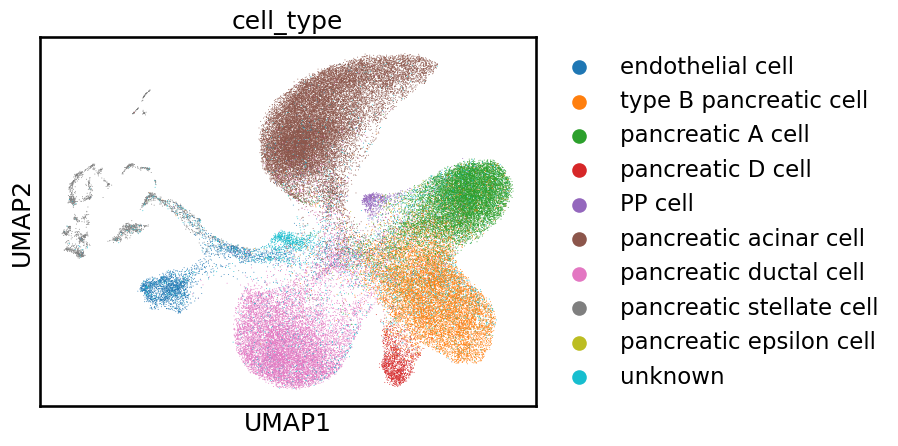

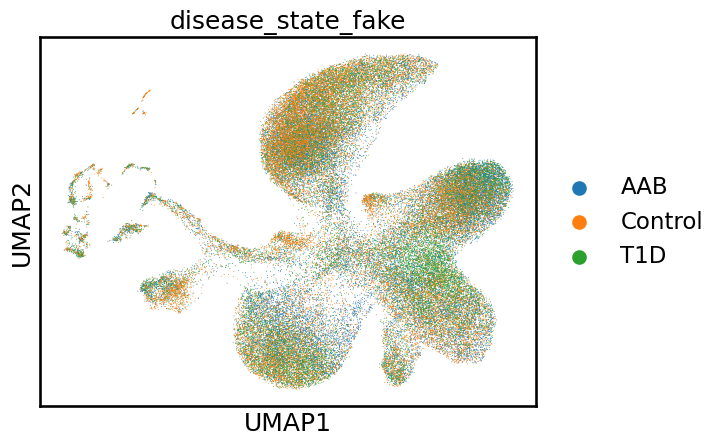

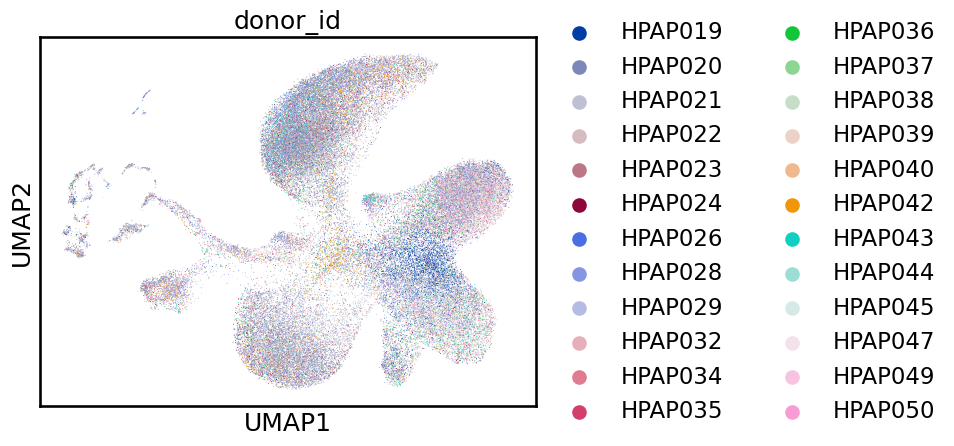

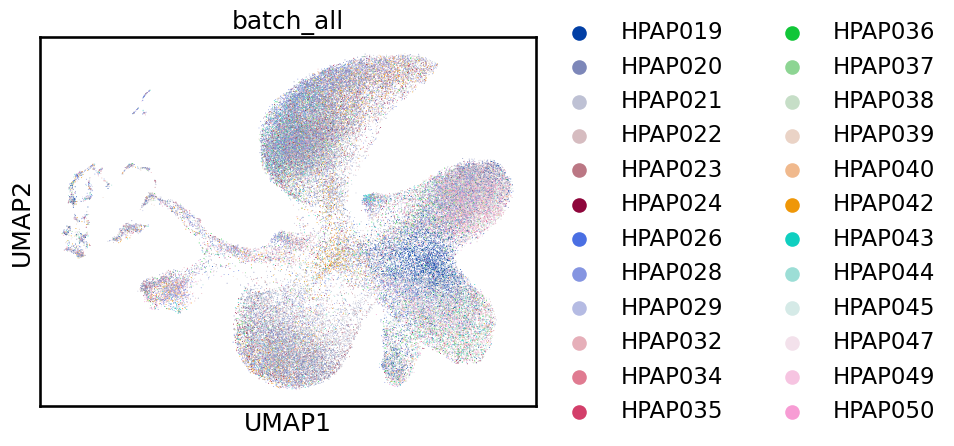

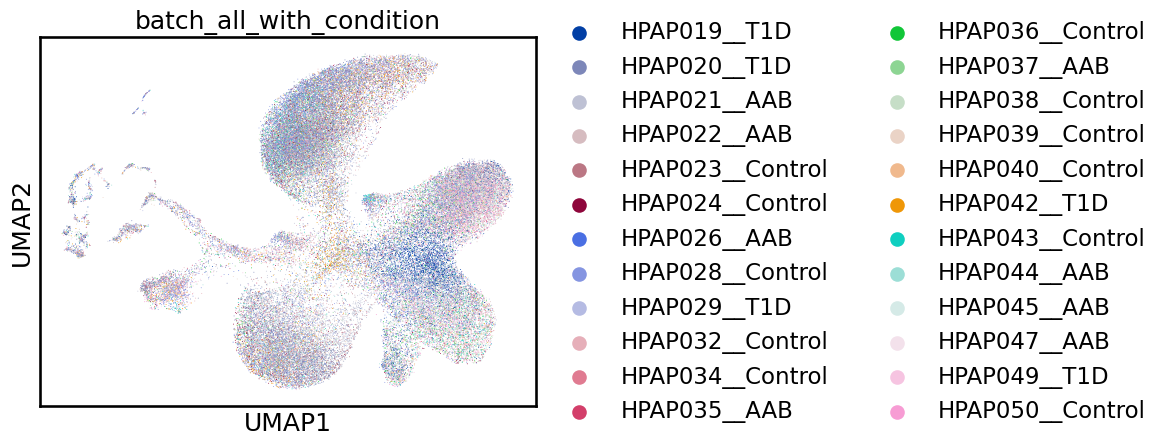

Plot of denoised expression


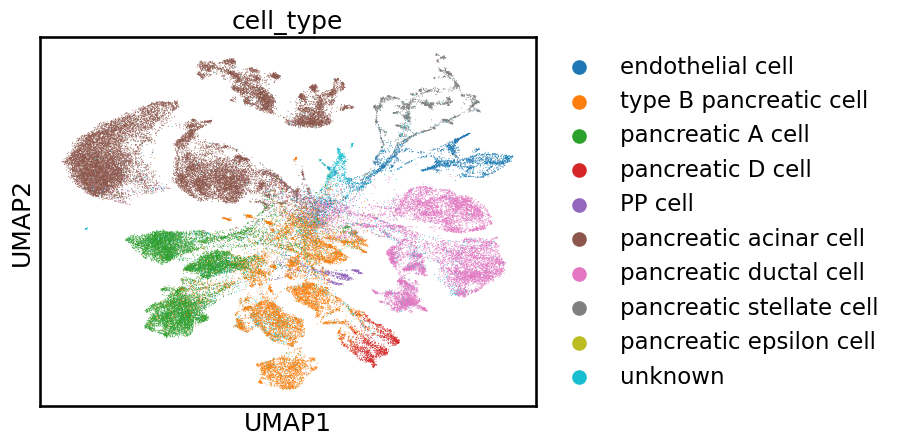

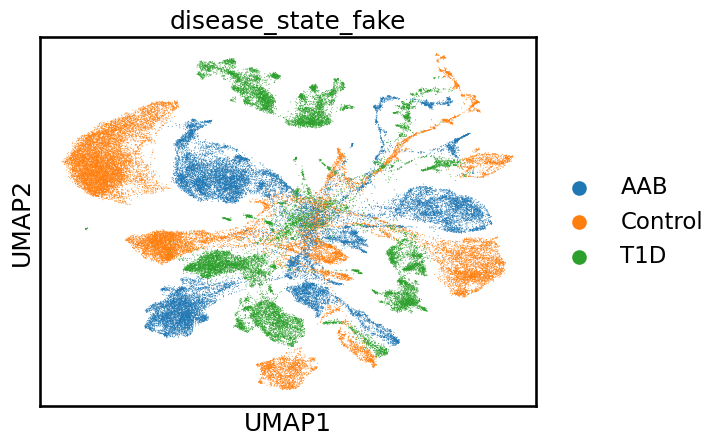

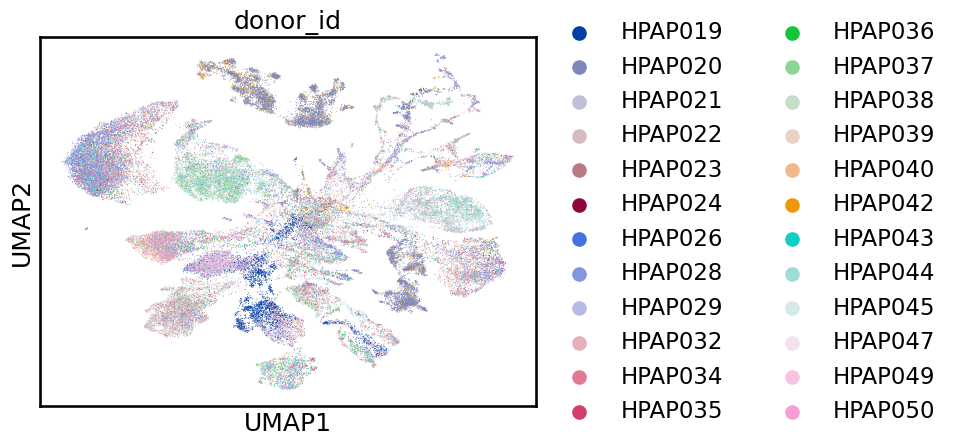

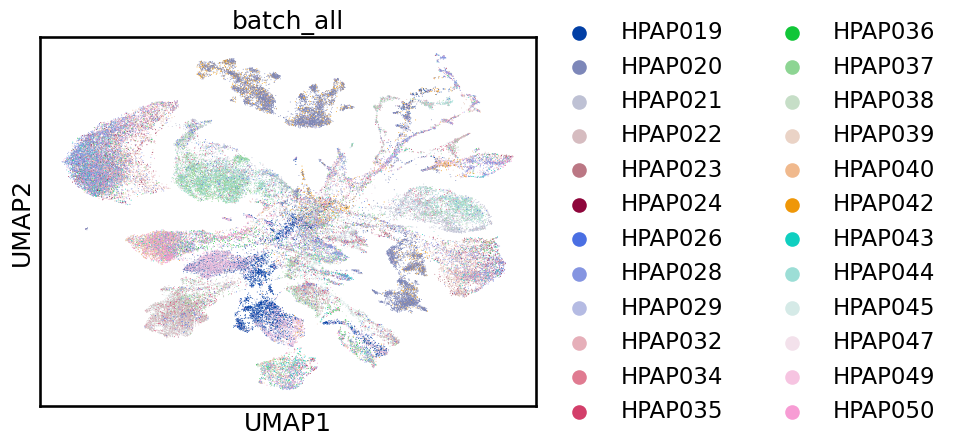

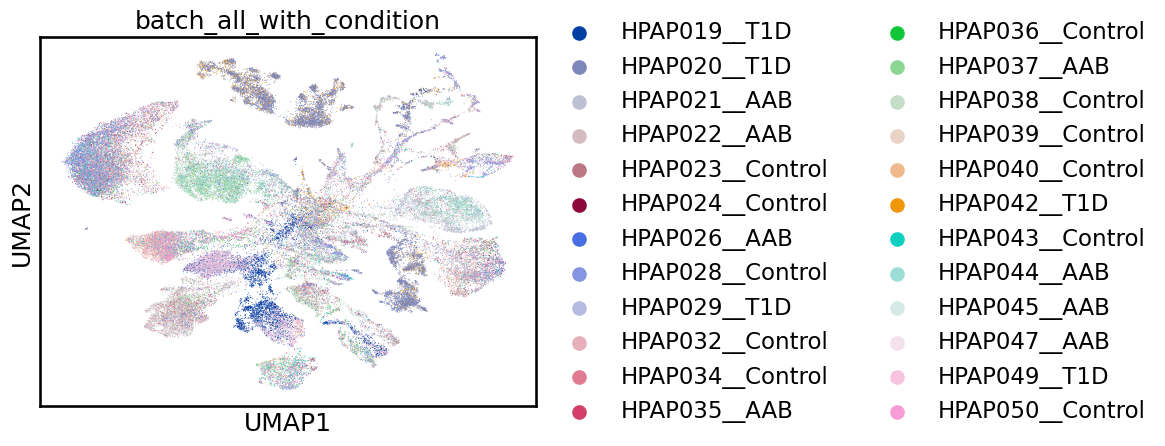

Finish adata preprocessing ====================
Batch effect:
condition-related mixing performance evaluation for main effect:
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9648637270297592 0.6772094869132169 0.7958413351789665


ASW---


asw_label 0.6822988390922546


asw_batch 0.934779309814721


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


Adding diffusion to step 14


Adding diffusion to step 15


Adding diffusion to step 16


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


Adding diffusion to step 14


kbet_score 0.49156409451289185
graph_conn 0.8585409843315276


NMI, ARI ---
NMI 0.7068637250790846
ARI 0.7847078058481954
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.682299  0.784708  0.706864  0.964864  0.677209   0.934779   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.491564            0.858541        0.0  0.858439   

       true pos rate   F1 LISI  
X_pca       0.562352  0.795841  
batch-related mixing performance evaluation for main effect:
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9648637270297592 0.18599752433885222 0.3118747187612332


ASW---


asw_label 0.6822988390922546


asw_batch 0.841155249115527


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


Adding diffusion to step 14


Adding diffusion to step 15


Adding diffusion to step 16


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


kbet_score 0.44344218569426497
graph_conn 0.8585409843315276


NMI, ARI ---
NMI 0.7068637250790846
ARI 0.7847078058481954
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.682299  0.784708  0.706864  0.964864  0.185998   0.841155   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.443442            0.858541        0.0  0.858439   

       true pos rate   F1 LISI  
X_pca       0.226463  0.311875  
batch-condition-related mixing performance evaluation for main effect:
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9648637270297592 0.18599752433885222 0.3118747187612332


ASW---


asw_label 0.6822988390922546


asw_batch 0.841155249115527


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


Adding diffusion to step 14


Adding diffusion to step 15


Adding diffusion to step 16


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


kbet_score 0.44315702999575446


graph_conn 0.8585409843315276


NMI, ARI ---
NMI 0.7068637250790846
ARI 0.7847078058481954
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.682299  0.784708  0.706864  0.964864  0.185998   0.841155   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.443157            0.858541        0.0  0.858439   

       true pos rate   F1 LISI  
X_pca       0.226463  0.311875  
Within each unique condition, evaluate the batch effect of the denoised expression
Within each unique condition, evaluate the batch effect of the denoised expression
Now evaluating AAB
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9686985393785859 0.2936560097926254 0.4506881968344354


ASW---


asw_label 0.6953725814819336


asw_batch 0.8635664665809287


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9


kbet_score 0.5542703354853243
graph_conn 0.8162356612173589


NMI, ARI ---
NMI 0.6914092348153047
ARI 0.7227418361870509
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.695373  0.722742  0.691409  0.968699  0.293656   0.863566   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca           0.55427            0.816236        0.0  0.872941   

       true pos rate   F1 LISI  
X_pca        0.29733  0.450688  


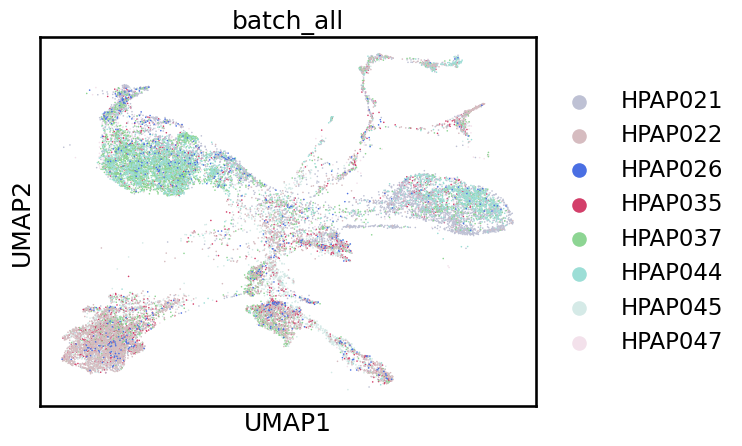

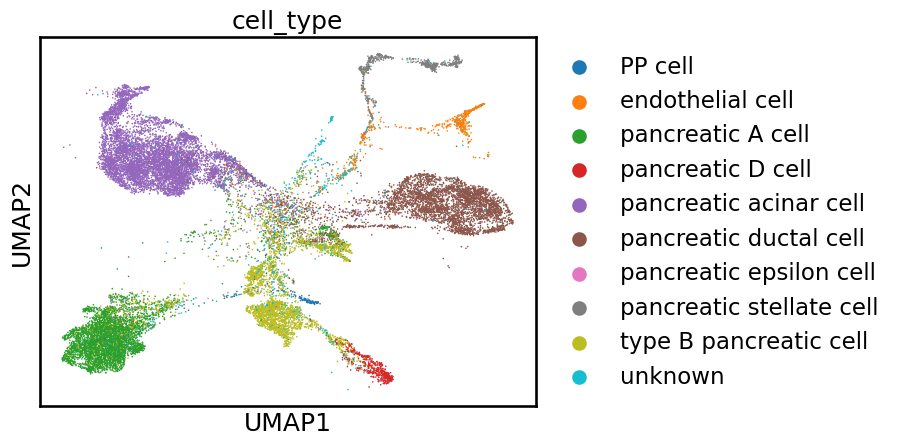

********************
Within each unique condition, evaluate the batch effect of the denoised expression
Now evaluating Control
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9710334381135239 0.2783092390080513 0.4326236222641235


ASW---


asw_label 0.730749785900116


asw_batch 0.8234919562504575


kBET---


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


Adding diffusion to step 7
Adding diffusion to step 8


Adding diffusion to step 9
Adding diffusion to step 10


Adding diffusion to step 11


kbet_score 0.503095906618226
graph_conn 0.8710052968205426


NMI, ARI ---
NMI 0.7140986493048193
ARI 0.8156281558142554
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca    0.73075  0.815628  0.714099  0.971033  0.278309   0.823492   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.503096            0.871005        0.0  0.887605   

       true pos rate   F1 LISI  
X_pca       0.402122  0.432624  


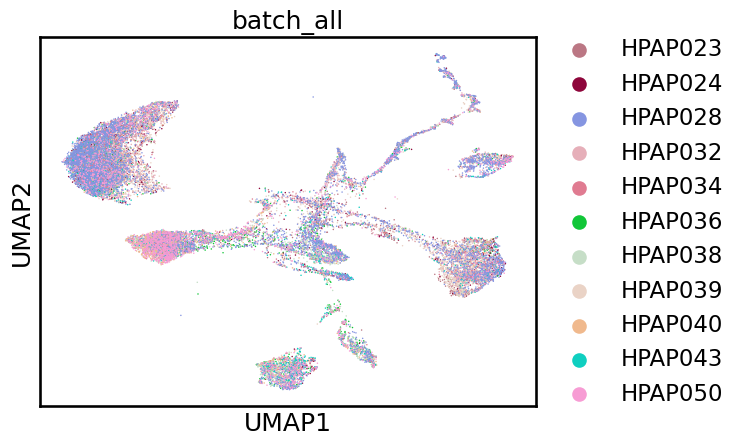

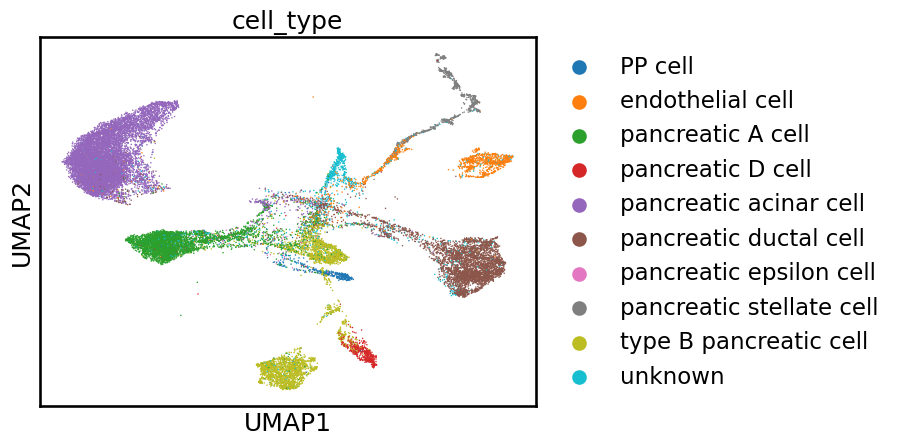

********************
Within each unique condition, evaluate the batch effect of the denoised expression
Now evaluating T1D
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9558097206156034 0.19012073560623094 0.31715580329744997


ASW---


asw_label 0.654619112610817


asw_batch 0.8731191496478623


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


kbet_score 0.5674566206176561
graph_conn 0.8536997211155309


NMI, ARI ---
NMI 0.61016224882125
ARI 0.4493689055395005
positive and true positive rate---


       ASW_label       ARI       NMI  1-cLISI     bLISI  ASW_batch  \
X_pca   0.654619  0.449369  0.610162  0.95581  0.190121   0.873119   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca          0.567457              0.8537        0.0  0.819446   

       true pos rate   F1 LISI  
X_pca       0.490405  0.317156  


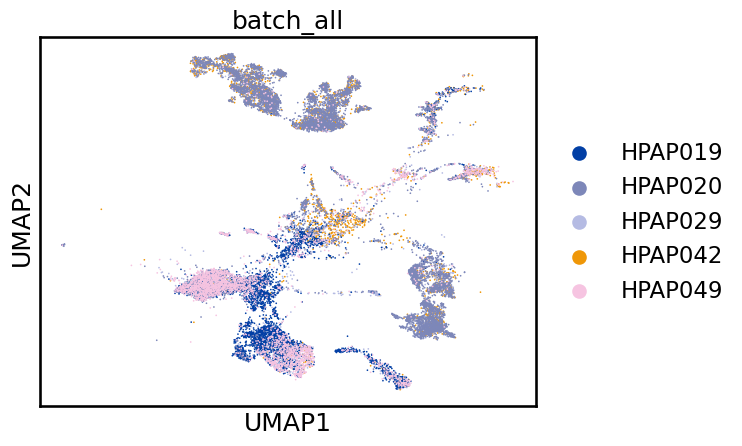

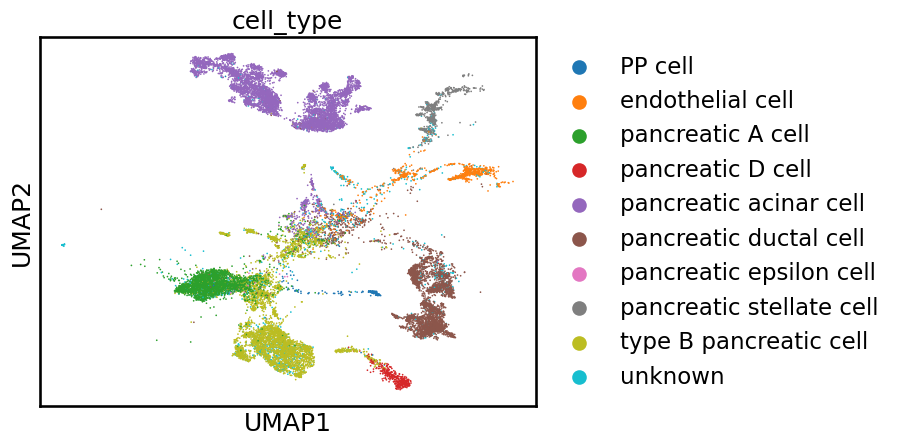

********************
Batch-related mixing performance evaluation for main effect:


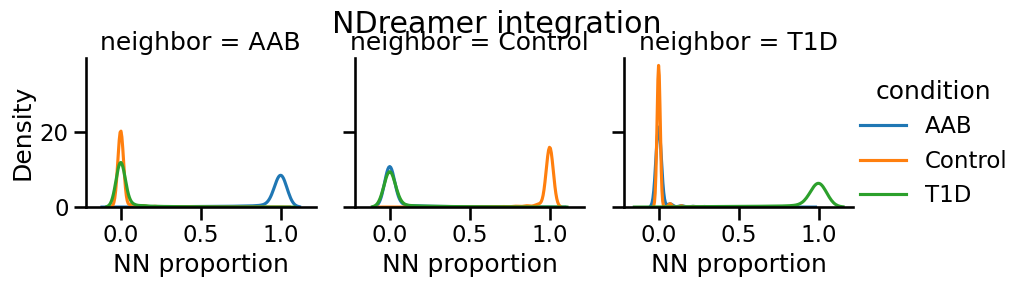

neighbor        AAB   Control       T1D
condition                              
AAB        0.949304  0.036471  0.014225
Control    0.015104  0.978607  0.006289
T1D        0.030698  0.041661  0.927641


In [11]:
i=0
evaluate_ndreamer_batch(dataset_name=dataset_names[i],cell_type_key=cell_type_keys[i],batch_key=batch_keys[i],condition_key=condition_keys[i])